# encoder模型

In [9]:
from datasets import EnglishChineseTranslateDatasets, EnglishFrenchTranslateDatasets
from data_generator import TranslateDataGenerator
import tensorflow as tf

# ds = EnglishChineseTranslateDatasets()
ds = EnglishFrenchTranslateDatasets()
test_x, test_y = ds.load_test_data()
test_x, test_y = test_x[: 512], test_y[: 512]
gen = TranslateDataGenerator(
    test_x, test_y, x_sentence_len=5, y_sentence_len=5, min_freq=0
)

gen.summary()
enc_x, x_len, dec_x, y_len, target_y = gen[: 1]

building source vocab...
building targe vocab...
converting x to enc_x...
converting y to dec_x...
case count: 512
source: 
  vocab size: 233
  enc_x avg len: 2.994140625
targe: 
  vocab size: 497
  dec_x avg len: 4.14453125


2023-02-24 20:46:47.353476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-24 20:46:47.353499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
[TensorShape([1, 64]), TensorShape([1, 64]), TensorShape([1, 64]), TensorShape([1, 64])]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_x (InputLayer)          [(None, 5)]               0         
                                                                 
 enc_embedding (Embedding)   (None, 5, 32)             7456      
                                                                 
 enc_gru_0 (GRU)             [(None, 5, 64),           18816     
                              (None, 64)]                        
                                                                 
 enc_gru_1 (GRU)             [(None, 5, 64),           24960     
                              (None, 64)]                        
                                                                 
 enc_gru_2 (GRU)             [(None, 5, 64),           24960     
    

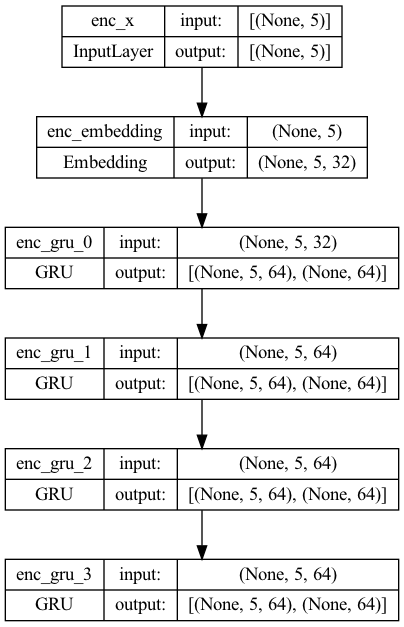

In [2]:
def add_encoder_layer(enc_x, vocab, embedding_size=32, hidden_units=64, gru_layers=4):
    enc_x = tf.keras.layers.Embedding(len(vocab), embedding_size, name="enc_embedding")(enc_x)
    states = []
    for i in range(gru_layers):
        enc_x, state = tf.keras.layers.GRU(hidden_units, go_backwards=True,
                                           return_state=True, return_sequences=True, name=f"enc_gru_{i}")(enc_x)
        states.append(state)
    return enc_x, states


enc_x_in = tf.keras.Input(gen.x_sentence_len, name="enc_x")
_, enc_states = add_encoder_layer(enc_x_in, gen.x_vocab)

m = tf.keras.Model(enc_x_in, enc_states)
print([s.shape for s in m(enc_x)])
m.summary()
tf.keras.utils.plot_model(m, show_shapes=True)

# encoder-decoder模型

(1, 10, 68)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_x (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 enc_embedding (Embedding)      (None, 10, 32)       1696        ['enc_x[0][0]']                  
                                                                                                  
 enc_gru_0 (GRU)                [(None, 10, 64),     18816       ['enc_embedding[0][0]']          
                                 (None, 64)]                                                      
                                                                                                  
 enc_gru_1 (GRU)                [(None, 10, 64),     24960       ['enc_gru_0[0][

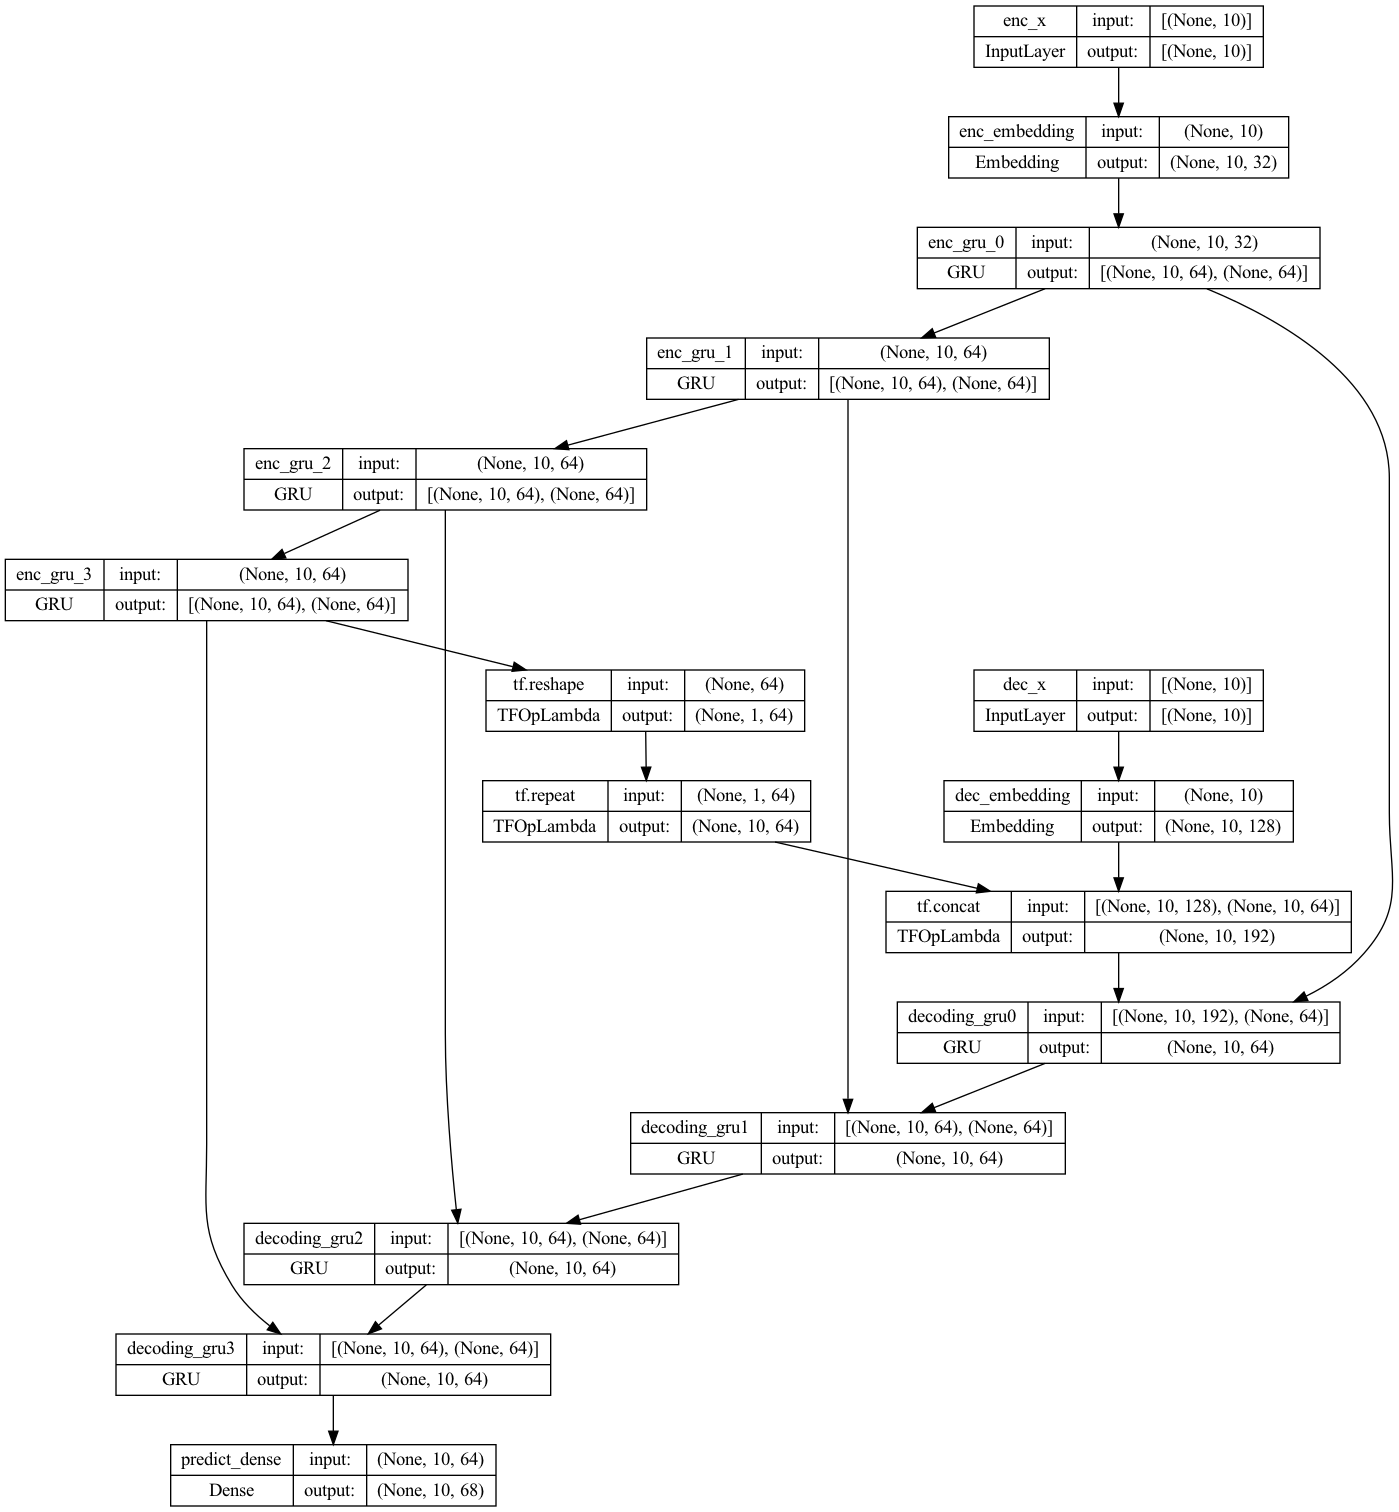

In [3]:
def add_decoder_layer(enc_states, dec_x, vocab, embedding_size=128, hidden_units=64):
    dec_x = tf.keras.layers.Embedding(len(vocab), embedding_size, name="dec_embedding")(dec_x)
    context = tf.reshape(enc_states[-1], shape=(-1, 1, enc_states[-1].shape[1]))
    time_steps = dec_x.shape[1]
    context = tf.repeat(context, repeats=time_steps, axis=1, name="enc_state_context")
    dec_x = tf.concat([
        dec_x, context
    ], axis=2, name="dec_x_with_context")
    for i, enc_state in enumerate(enc_states):
        dec_x = tf.keras.layers.GRU(hidden_units, go_backwards=True, return_state=False,
                                    return_sequences=True, name=f"decoding_gru{i}")(dec_x, initial_state=enc_state)
    dec_x = tf.keras.layers.Dense(len(vocab), activation="softmax", name="predict_dense")(dec_x)
    return dec_x


dec_x_in = tf.keras.Input(gen.y_sentence_len, name="dec_x")

y = add_decoder_layer(enc_states, dec_x_in, gen.y_vocab)
m = tf.keras.Model([enc_x_in, dec_x_in], y)
print(m([enc_x, dec_x]).shape)
m.summary()
tf.keras.utils.plot_model(m, show_shapes=True)

# 损失函数

In [3]:
import numpy as np


def sequence_mask(x, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    max_len = x.shape[1]
    mask = tf.range(start=0, limit=max_len, dtype=tf.float32)[
           None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)
    print(mask.numpy())

    if len(x.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), x, value)
    else:
        return tf.where(mask, x, value)


x = np.arange(20).reshape((2, 10))
print(sequence_mask(x, np.array([3, 5])).numpy())

[[ True  True  True False False False False False False False]
 [ True  True  True  True  True False False False False False]]
[[ 0  1  2  0  0  0  0  0  0  0]
 [10 11 12 13 14  0  0  0  0  0]]


In [4]:
def masked_sparse_categorical_cross_entropy(y_true, y_pred, valid_len):
    weights = tf.ones_like(y_true, dtype=tf.float32)
    print("weights: ", weights.numpy())
    weights = sequence_mask(weights, valid_len)
    print("masked weights: ", weights.numpy())
    label_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
    print("label_one_hot: ", label_one_hot.numpy())
    unweighted_loss = tf.keras.losses.CategoricalCrossentropy(reduction='none')(label_one_hot, y_pred)
    print("unweight loss: ", unweighted_loss.numpy())
    weighted_loss = unweighted_loss * weights
    print("weighted_loss: ", weighted_loss)
    loss = tf.reduce_mean(weighted_loss, axis=1)
    print("loss: ", loss.numpy())


y_true = np.arange(6).reshape((2, 3))
valid_len = np.array([
    2, 1
])
y_pred = tf.one_hot(np.array([
    [0, 2, 1],
    [3, 4, 0]
]), depth=6)
print("y_pred: ", y_pred.numpy())
masked_sparse_categorical_cross_entropy(y_true, y_pred, valid_len)
# cce = tf.keras.losses.CategoricalCrossentropy()
# y_true = [[0, 1, 0]]
# y_pred = [[1.0, 0.0, 0]]
# print(cce(y_true, y_pred))

y_pred:  [[[1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0.]]]
weights:  [[1. 1. 1.]
 [1. 1. 1.]]
[[ True  True False]
 [ True False False]]
masked weights:  [[1. 1. 0.]
 [1. 0. 0.]]
label_one_hot:  [[[1. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1.]]]
unweight loss:  [[8.2629583e-08 1.6118095e+01 1.6118095e+01]
 [8.2629583e-08 8.2629583e-08 1.6118095e+01]]
weighted_loss:  tf.Tensor(
[[8.2629583e-08 1.6118095e+01 0.0000000e+00]
 [8.2629583e-08 0.0000000e+00 0.0000000e+00]], shape=(2, 3), dtype=float32)
loss:  [5.3726988e+00 2.7543194e-08]


# 模型训练

In [11]:
from translate_model import Seq2SeqTranslateModel
import tensorflow as tf
import numpy as np

m = Seq2SeqTranslateModel(
    enc_vocab_size=len(gen.x_vocab), enc_embedding_size=64,
    dec_vocab_size=len(gen.y_vocab), dec_embedding_size=64,
    dropout=0.1, gru_layers=2, gru_hidden_units=128
)

In [12]:
print(f"all cases: {len(gen)}")
for lr in [2e-2, 1e-2, 8e-3, 5e-3, 3e-3, 1e-3]:
    m.custom_fit(
        gen,
        batch_size=64,
        epochs=50,
        learning_rate=lr
    )

all cases: 512
Epoch 1/50
[=========================================================================] 100%
Epoch 1, Loss: 4.0400
Epoch 2/50
[=========================================================================] 100%
Epoch 2, Loss: 3.5569
Epoch 3/50
[=========================================================================] 100%
Epoch 3, Loss: 3.3113
Epoch 4/50
[=========================================================================] 100%
Epoch 4, Loss: 3.2021
Epoch 5/50
[=========================================================================] 100%
Epoch 5, Loss: 3.1439
Epoch 6/50
[=========================================================================] 100%
Epoch 6, Loss: 4.9651
Epoch 7/50
[=========================================================================] 100%
Epoch 7, Loss: 3.6657
Epoch 8/50
[=========================================================================] 100%
Epoch 8, Loss: 3.3443
Epoch 9/50
[=============================================================

[=========================================================================] 100%
Epoch 22, Loss: 1.4461
Epoch 23/50
[=========================================================================] 100%
Epoch 23, Loss: 1.4528
Epoch 24/50
[=========================================================================] 100%
Epoch 24, Loss: 1.4159
Epoch 25/50
[=========================================================================] 100%
Epoch 25, Loss: 1.4067
Epoch 26/50
[=========================================================================] 100%
Epoch 26, Loss: 1.3660
Epoch 27/50
[=========================================================================] 100%
Epoch 27, Loss: 1.3659
Epoch 28/50
[=========================================================================] 100%
Epoch 28, Loss: 1.3441
Epoch 29/50
[=========================================================================] 100%
Epoch 29, Loss: 1.3532
Epoch 30/50
[=======================================================================

[=========================================================================] 100%
Epoch 43, Loss: 0.6985
Epoch 44/50
[=========================================================================] 100%
Epoch 44, Loss: 0.6473
Epoch 45/50
[=========================================================================] 100%
Epoch 45, Loss: 0.6085
Epoch 46/50
[=========================================================================] 100%
Epoch 46, Loss: 0.5912
Epoch 47/50
[=========================================================================] 100%
Epoch 47, Loss: 0.5941
Epoch 48/50
[=========================================================================] 100%
Epoch 48, Loss: 0.5475
Epoch 49/50
[=========================================================================] 100%
Epoch 49, Loss: 0.5325
Epoch 50/50
[=========================================================================] 100%
Epoch 50, Loss: 0.5646
Epoch 1/50
[========================================================================

[=========================================================================] 100%
Epoch 14, Loss: 0.4608
Epoch 15/50
[=========================================================================] 100%
Epoch 15, Loss: 0.4683
Epoch 16/50
[=========================================================================] 100%
Epoch 16, Loss: 0.4626
Epoch 17/50
[=========================================================================] 100%
Epoch 17, Loss: 0.4440
Epoch 18/50
[=========================================================================] 100%
Epoch 18, Loss: 0.4353
Epoch 19/50
[=========================================================================] 100%
Epoch 19, Loss: 0.4284
Epoch 20/50
[=========================================================================] 100%
Epoch 20, Loss: 0.4141
Epoch 21/50
[=========================================================================] 100%
Epoch 21, Loss: 0.4047
Epoch 22/50
[=======================================================================

[=========================================================================] 100%
Epoch 35, Loss: 0.3862
Epoch 36/50
[=========================================================================] 100%
Epoch 36, Loss: 0.3831
Epoch 37/50
[=========================================================================] 100%
Epoch 37, Loss: 0.4017
Epoch 38/50
[=========================================================================] 100%
Epoch 38, Loss: 0.4001
Epoch 39/50
[=========================================================================] 100%
Epoch 39, Loss: 0.3893
Epoch 40/50
[=========================================================================] 100%
Epoch 40, Loss: 0.3818
Epoch 41/50
[=========================================================================] 100%
Epoch 41, Loss: 0.3808
Epoch 42/50
[=========================================================================] 100%
Epoch 42, Loss: 0.3778
Epoch 43/50
[=======================================================================

# 翻译测试

In [7]:
idx = 1
sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[idx: idx + 1]
print(gen.x[idx], sub_enc_valid_len[0])
print(gen.x_vocab.to_tokens(list(sub_enc_x[0])))
print(gen.y[idx], sub_target_valid_len[0])
print(gen.y_vocab.to_tokens(list(sub_dec_x[0])))
print(gen.y_vocab.to_tokens(list(sub_target_y[0])))

y_pred, _ = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
print(y_pred)

hi . 2
['hi', '.', '<pad>', '<pad>', '<pad>']
salut ! 3
['<bos>', 'salut', '!', '<pad>', '<pad>']
['salut', '!', '<eos>', '<pad>', '<pad>']
salut salut !


# BLEU评测

In [7]:
from translate_model import bleu_acc

print(bleu_acc(list('你好!'), list('你好!'), 3))
print(bleu_acc('hello world !'.split(), 'hello !'.split(), 3))

1.0
0.6065306597126334


In [8]:
from translate_model import bleu_acc

for i in range(40, 60):
    sub_enc_x, sub_enc_valid_len, sub_dec_x, sub_target_valid_len, sub_target_y = gen[i: i + 1]
    y_pred, _ = m.translate(sub_enc_x, sub_enc_valid_len, dec_vocab=gen.y_vocab, max_len=gen.y_sentence_len)
    x = gen.x_vocab.to_tokens(list(sub_enc_x[0]))[: sub_enc_valid_len[0]]
    y_pred = y_pred.split()
    label = gen.y_vocab.to_tokens(list(sub_target_y[0]))[: sub_target_valid_len[0] - 1]
    print(x, " -> ", label)
    print(y_pred)
    print(" BLEU: ", bleu_acc(label, y_pred, 3))

['hop', 'in', '.']  ->  ['monte', '.']
['joignez-vous', 'ouvre', '.']
 BLEU:  0.0
['hop', 'in', '.']  ->  ['montez', '.']
['joignez-vous', 'ouvre', '.']
 BLEU:  0.0
['hug', 'me', '.']  ->  ['serre-moi', 'dans', 'tes', 'bras', '!']
['salut', 'salut', '!']
 BLEU:  0.0
['hug', 'me', '.']  ->  ['serrez-moi', 'dans', 'vos', 'bras', '!']
['salut', 'salut', '!']
 BLEU:  0.0
['i', 'fell', '.']  ->  ['je', 'suis', 'tombée', '.']
["j'ai", 'capté', '.']
 BLEU:  0.0
['i', 'fell', '.']  ->  ['je', 'suis', 'tombé', '.']
["j'ai", 'capté', '.']
 BLEU:  0.0
['i', 'know', '.']  ->  ['je', 'sais', '.']
["j'ai", 'le', 'emporté', '.']
 BLEU:  0.0
['i', 'left', '.']  ->  ['je', 'suis', 'parti', '.']
["j'ai", 'le', 'emporté', '.']
 BLEU:  0.0
['i', 'left', '.']  ->  ['je', 'suis', 'partie', '.']
["j'ai", 'le', 'emporté', '.']
 BLEU:  0.0
['i', 'lost', '.']  ->  ["j'ai", 'perdu', '.']
["j'ai", 'capté', '?', 'perdu', '.']
 BLEU:  0.0
['i', 'paid', '.']  ->  ['j’ai', 'payé', '.']
["j'ai", 'j’ai', 'fait', '.']
 